# Equazione di Schrödinger

In questo esercizio si vuole risolvere l'equazione di Schrödinger dipendente dal tempo per un elettrone in una scatola di potenziale a pareti impenetrabili, utilizzando dapprima il metodo di Crank-Nicolson e poi quello spettrale.

## Introduzione

Per scatola di potenziale si intende un potenziale uniforme in tutto lo spazio fuorchè in un dominio rettangolare, all'interno del quale è ancora uniforme ma assume un valore inferiore rispetto all'esterno. Si dice che la _scatola_ ha pareti impenetrabili se nella regione esterna il potenziale diverge positivamente, infatti si dimostra che la funzione d'onda in questa regione e sulla sua frontiera deve essere nulla. Inoltre si può mostrare che le funzioni d'onda sono continue anche nei punti in cui il potenziale ha delle discontinuità.

In particolare nel caso unidimensionale il dominio rettangolare è un intervallo $[0,L]$ (entro cui di seguito si pone che il potenziale sia nullo) e l'equazione di Schrödinger è una equazione differenziale alle derivate parziali (del secondo ordine) in due variabili.

Per quanto detto, risolvere l'equazione di Schrödinger per una particella in una scatola di potenziale unidimensionale a pareti impenetrabili corrisponde ad integrare l'equazione libera

\begin{equation}
i \hbar \frac{\partial}{\partial t} \psi (t,x) = -\frac{\hbar^2}{2 m} \psi (t,x)
\end{equation}

con il vincolo $\forall t: \psi (t,0) = \psi(t,L) = 0$.

## Operazioni preliminari

Inoltre si importano i sottomoduli `scipy.linalg`, che contiene le funzioni di algebra lineare necessarie per il metodo di Crank-Nicolson, e `scipy.fftpack`, che contiene le trasformate veloci necessarie per implementare il metodo spettrale.

Si può importare il valore di diverse costanti tramite il sottomodulo `scipy.constants`.

In [1]:
# importing modules
import numpy as np
import scipy.linalg as la
from math import sin, cos, sqrt, pi
from scipy.constants import hbar, m_e
from scipy.fftpack import dst

import matplotlib.pyplot as plt
import matplotlib.animation as animation

# display configurations
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
from base64 import b64encode
from IPython.display import HTML

def video(filename):
    video_tag = '''<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>'''
    raw = open(filename,'rb').read()
    encoded = b64encode(raw)
    encoded_ascii = video_tag.format(encoded.decode('ascii'))
    return HTML(data=encoded_ascii)

Vengono anche fissati i valori dei parametri che in questo caso sono la lunghezza $L$ e la durata dell'intervallo di tempo entro cui viene calcolata la soluzione (le unità sono quelle del sistema internazionale).

In [3]:
L = 1e-8 
Nx = 1000
xx = np.linspace(0.0,L,Nx)

h = 1e-18
Nt = 2000
tt = h*np.arange(Nt)

Per ultimo si prepara il vettore delle condizioni iniziali. In questo esercizio le condizioni iniziali per la funzione d'onda sono un pacchetto d'onda gaussiano centrato in $\dfrac{L}{2}$ con impulso $k$ positivo. Si trascura di normalizzare ad $1$ la funzione d'onda.

In [4]:
def psiInit(nt,nx,sigma=1e-10,k=5e10,x0=L/2):
    psi = np.empty([nt,nx],dtype=complex)
    xx = np.linspace(0.0,L,nx)
    psi[0,:] = np.exp(-(xx-x0)**2/(2*sigma**2) + 1j*k*xx)
    return psi

psi = psiInit(Nt,Nx)

Si può visualizzare la parte reale ed il modulo della funzione d'onda nelle condizioni iniziali.

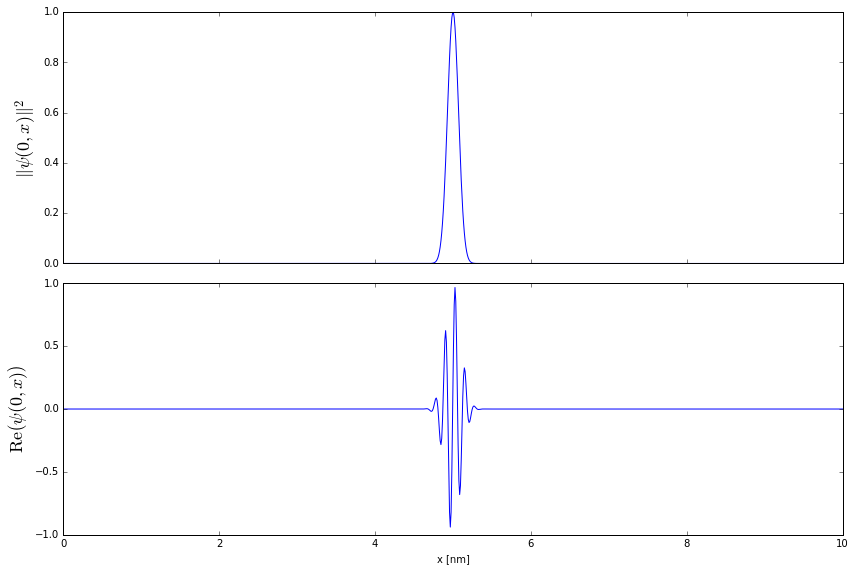

In [5]:
ax1 = plt.subplot(212)
plt.plot(1e9*xx,psi[0,:].real)
plt.ylabel(r"$\mathrm{Re} \left(\psi(0,x)\right)$", fontsize=18)
plt.xlabel("x [nm]")

ax2 = plt.subplot(211, sharex=ax1)
plt.plot(1e9*xx,np.abs(psi[0,:])**2)
plt.ylabel(r"$\Vert \psi(0,x) \Vert^2$", fontsize=18)
plt.setp(ax2.get_xticklabels(), visible=False)

plt.tight_layout()

## Metodo di Crank-Nicolson

Viene implementato il metodo di Crank-Nicolson grazie alla funzione `solve_banded` del modulo `scipy.linalg`. Quest'ultima permette di risolvere in tramite algoritmi ottimizzati sistemi lineari in cui la matrice dei coefficienti abbia elementi tutti nulli tranne che su certe diagonali.

Si osserva che la matrice dei coefficienti che deve essere passata alla funzione `solve_banded` deve essere nella seguente forma. La prima riga deve contenere la $n$-esima diagonale superiore non nulla con $n$ zeri iniziali, la successiva riga deve contenere la $(n-1)$-esima diagonale con $n-1$ zeri iniziali e così via fino alla diagonale principale (che non è preceduta da zeri), la riga successiva contiene la prima diagonale inferiore seguita da uno zero, la seconda da due zeri e così via fino all'ultima diagonale inferiore non nulla.

In [6]:
a = L/Nx
d = 0.5*h*hbar/(m_e*a**2)*1j

A = np.empty([3,Nx],dtype=complex)

A[0,0], A[0,1:] = 0, -0.5*d*np.ones(Nx-1)
A[1,:] = (1+d)*np.ones(Nx)
A[2,:-1], A[2,-1] = -0.5*d*np.ones(Nx-1), 0

def stepSource(psi):
    v = np.empty_like(psi)
    v[0], v[-1] = psi[0], psi[-1]
    v[1:-1] = (1-d)*psi[1:-1] + 0.5*d*(psi[:-2]+psi[2:])
    return v

def crankNicolson(psi):
    nt,_ = psi.shape
    for i in range(1,Nt):
        B = stepSource(psi[i-1,])
        psi[i,] = la.solve_banded((1,1),A,B)

### Animazione della soluzione

A questo punto è possibile integrare l'equazione di Schrödinger tramite le funzioni implementate in precedenza e visualizzare una animazione della parte reale della funzione d'onda.

In [7]:
psi1 = psiInit(Nt,Nx)
crankNicolson(psi1)

In [8]:
# adapted from http://matplotlib.org/1.4.1/examples/animation/double_pendulum_animated.html

tstep = 10

fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(0.0,L), ylim=(-1,1))
ax.grid()

line, = ax.plot([], [], lw=2)
time_template = 'time = %.1es'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes, fontsize=15)

def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text

def animate(i, psi):
    line.set_data(xx,psi[i,:].real)
    time_text.set_text(time_template % tt[i])
    return line, time_text

anim = animation.FuncAnimation(fig, lambda i: animate(i, psi1), range(0,Nt,tstep), interval=50, blit=True, init_func=init)
anim.save('media/crank-nicolson.mp4', fps=20, extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])
plt.close(fig)
video('media/crank-nicolson.mp4')

## Metodo spettrale

Si implementa il metodo spettrale utilizzando la funzione `dst` contenuta in `scipy.fftpack`, la quale computa la trasformata veloce di tipo seno. Si fanno alcune osservazioni in merito:

- Se $\{x_0, x_1, \cdots, x_{N-1}\}$ è la successione da trasformare allora deve essere $x_0 = 0$ e, per la particolare implementazione di questa funzione, bisogna passare il vettore $\{x_1, x_2, \cdots, x_n\}$
- Tramite l'argomento opzionale `type` è possibile scegliere il tipo di trasformata seno, quella utilizzata nel metodo spettrale è del primo tipo. Quest'ultima è definita nel modulo `scipy.fftpack` nel modo seguente:
\begin{equation}
y_k = 2 \sum^{N-1}_{n=0} \sin \left( \frac{\pi (n+1)(k+1)}{N+1} \right) x_n
\end{equation}
- Benchè nel modulo `scipy.fftpack` sia definita la funzione `idst` quest'ultima è solo un alias per `dst`, infatti la trasformata seno di primo tipo è l'inversa di se stessa salvo una costante moltiplicativa. Dalla definizione adottata questa costante moltiplicativa è $(2 N)^{-1}$.

In [9]:
def spectrl(psi):
    nt, nx = psi.shape
    y = np.empty([nt,nx-1],dtype=complex)
    y[0,] = psi[0,1:]
    C0 = dst(y[0,],type=1)
    kk = (pi/L)*np.arange(nx-1)
    Mk, Mt = np.meshgrid(kk,tt)
    Ct = C0*np.exp((-0.5j*hbar*Mk**2/m_e)*Mt)
    psi[:,0] = 0.0
    psi[:,1:] = dst(Ct,axis=1,type=1)/(2*Nx)

### Animazione della soluzione

Analogamente al metodo di Crank-Nicolson è possibile visualizzare semplicemente la soluzione.

In [10]:
psi2 = psiInit(Nt,Nx)
spectrl(psi2)

In [11]:
# adapted from http://matplotlib.org/1.4.1/examples/animation/double_pendulum_animated.html

tstep = 10

fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(0.0,L), ylim=(-1,1))
ax.grid()

line, = ax.plot([], [], lw=2)
time_template = 'time = %.1es'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes, fontsize=15)

def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text

def animate(i):
    line.set_data(xx,psi2[i,:].real)
    time_text.set_text(time_template % tt[i])
    return line, time_text

anim = animation.FuncAnimation(fig, animate, range(0,Nt,tstep), interval=50, blit=True, init_func=init)
anim.save('media/spectral.mp4', fps=20, extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])
plt.close(fig)
video('media/spectral.mp4')